## 1. Import & load libraries

In [1]:
%pip cache purge

%pip install mne
%pip install matplotlib
%pip install numpy
%pip install pandas
%pip install scikit-learn


Files removed: 4 (38 kB)
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.python.org/simple
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.python.org/simple
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.python.org/simple
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.python.org/simple
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.python.org/simple
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip list


Package            Version
------------------ -----------
asttokens          3.0.0
certifi            2025.1.31
charset-normalizer 3.4.1
colorama           0.4.4
comm               0.2.2
contourpy          1.3.1
cycler             0.12.1
debugpy            1.8.12
decorator          5.1.1
exceptiongroup     1.2.2
executing          2.1.0
fonttools          4.56.0
idna               3.10
importlib_metadata 8.6.1
ipykernel          6.29.5
ipython            8.32.0
jedi               0.19.2
Jinja2             3.1.5
joblib             1.4.2
jupyter_client     8.6.3
jupyter_core       5.7.2
kiwisolver         1.4.8
lazy_loader        0.4
MarkupSafe         3.0.2
matplotlib         3.9.4
matplotlib-inline  0.1.7
mne                1.9.0
nest_asyncio       1.6.0
numpy              2.0.2
packaging          24.2
pandas             2.2.3
parso              0.8.4
pexpect            4.9.0
pickleshare        0.7.5
pillow             11.1.0
pip                25.0
platformdirs       4.3.6
pooch      

In [3]:
import mne
from mne.datasets import eegbci
from mne.io import read_raw_edf
from mne.io import concatenate_raws
from mne.preprocessing import ICA

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from io import BytesIO
from PIL import Image

import os
import re
import warnings
import glob
import logging

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from typing import List, Tuple, Dict, Optional


In [4]:
warnings.filterwarnings("ignore", message="FigureCanvasAgg is non-interactive, and thus cannot be shown")
warnings.filterwarnings("ignore", category=RuntimeWarning, message="Channel locations not available.*")


## 2. Info

### Experimental Protocol

This data set consists of over 1500 one- and two-minute EEG recordings, obtained from ***109 volunteers***, as described below.

Subjects performed different motor/imagery tasks while 64-channel EEG were recorded using the BCI2000 system (http://www.bci2000.org). Each subject performed ***14 experimental runs***: two one-minute baseline runs (one with eyes open, one with eyes closed), and three two-minute runs of each of the four following tasks:

- **TASK 1**: A target appears on either the left or the right side of the screen. The subject opens and closes the corresponding fist until the target disappears. Then the subject relaxes.
- **TASK 2**: A target appears on either the left or the right side of the screen. The subject imagines opening and closing the corresponding fist until the target disappears. Then the subject relaxes.
- **TASK 3**: A target appears on either the top or the bottom of the screen. The subject opens and closes either both fists (if the target is on top) or both feet (if the target is on the bottom) until the target disappears. Then the subject relaxes.
- **TASK 4**: A target appears on either the top or the bottom of the screen. The subject imagines opening and closing either both fists (if the target is on top) or both feet (if the target is on the bottom) until the target disappears. Then the subject relaxes.

### Description of data:

The experimental runs were:

- Baseline, eyes open
- Baseline, eyes closed
- Task 1 (open and close left or right fist)
- Task 2 (imagine opening and closing left or right fist)
- Task 3 (open and close both fists or both feet)
- Task 4 (imagine opening and closing both fists or both feet)

Each annotation includes one of three codes (T0, T1, or T2):

- **T0** corresponds to rest
- **T1** corresponds to onset of motion (real or imagined) of
        the left fist (in runs 3, 4, 7, 8, 11, and 12)
        both fists (in runs 5, 6, 9, 10, 13, and 14)
- **T2** corresponds to onset of motion (real or imagined) of
        the right fist (in runs 3, 4, 7, 8, 11, and 12)
        both feet (in runs 5, 6, 9, 10, 13, and 14)

| Run       | Task                                |
|-----------|-------------------------------------|
| 1         | Baseline, eyes open                 |
| 2         | Baseline, eyes closed               |
| 3, 7, 11  | Motor execution: left vs right hand |
| 4, 8, 12  | Motor imagery: left vs right hand   |
| 5, 9, 13  | Motor execution: hands vs feet      |
| 6, 10, 14 | Motor imagery: hands vs feet        |


The EEGs were recorded from 64 electrodes as per the international system (excluding electrodes Nz, F9, F10, FT9, FT10, A1, A2, TP9, TP10, P9, and P10)

<img width=100% src=../images/EGG_64.png>

<img width=100% src=../images/64_channel_sharbrough.png>


## 3. Load data

In [5]:
def load_data(subjects, runs, data_dir="../data/files/"):
    """
    Load and preprocess EEG data for given subjects and runs.
    """
    all_raws = []

    for subject in subjects:
        print(f"\n=== Loading data from_volunteer {subject} ===")
        try:
            # Download data to the specified directory
            raw_fnames = mne.datasets.eegbci.load_data(subject, runs, path=data_dir)
            raws = [mne.io.read_raw_edf(f, preload=True, verbose=True) for f in raw_fnames]  
            raw = mne.concatenate_raws(raws)
        except Exception as e:
            warnings.warn(f"Skipping subject {subject} due to an error: {e}")
            continue

        # Set standard montage
        try:
            raw.set_montage("standard_1005", on_missing="ignore")
        except Exception as e:
            warnings.warn(f"Could not set montage for subject {subject}: {e}")

        # Extract events from annotations
        try:
            events, _ = mne.events_from_annotations(raw)
            new_annot = mne.annotations_from_events(
                events=events, 
                event_desc=new_labels_events, 
                sfreq=raw.info['sfreq'], 
                orig_time=raw.info['meas_date']
                )
            raw.set_annotations(new_annot)
        except Exception as e:
            warnings.warn(f"Could not update event labels for subject {subject}: {e}")

        all_raws.append(raw)

    if not all_raws:
        raise ValueError("No valid EEG data loaded. Check subject and run IDs.")

    # Concatenate all subjects' data
    return mne.concatenate_raws(all_raws)


In [6]:
subjects = [1] # subjects to load (from 1 to 109 volunteers)

runs = [3]  # experimental runs for each subject
# runs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

raw_data = load_data(subjects, runs)



=== Loading data from_volunteer 1 ===
Extracting EDF parameters from /home/dgerwig-/OneDrive/code_dgerwig/42_Cursus_Outer_Core/vortex/42_vortex/data/files/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]


/tmp/ipykernel_3889031/3043060375.py:35: UserWarning: Could not update event labels for subject 1: name 'new_labels_events' is not defined
  warnings.warn(f"Could not update event labels for subject {subject}: {e}")


In [7]:
print(raw_data)


<RawEDF | S001R03.edf, 64 x 20000 (125.0 s), ~9.8 MiB, data loaded>


In [8]:
def summarize_edf_files(data_dir="../data/files/"):
    """
    Recursively summarize the contents of all .edf files in the given directory.
    """
    edf_files = glob.glob(os.path.join(data_dir, "**/*.edf"), recursive=True)
    
    if not edf_files:
        print("No EDF files found in the directory or subdirectories.")
        return
    
    print(f"Found {len(edf_files)} EDF files in {data_dir}**:\n")
    
    for edf_file in edf_files:
        try:
            raw = mne.io.read_raw_edf(edf_file, preload=False, verbose=False)
            info = raw.info
            
            rel_path = os.path.relpath(edf_file, data_dir)  # Get relative path for better readability
            
            print(f"File: {rel_path}")
            print(f"  - Channels: {len(info['ch_names'])}")
            print(f"  - Length: {len(raw)}")
            print(f"  - Sampling Frequency: {info['sfreq']} Hz")
            print("-" * 40)
        
        except Exception as e:
            print(f"Error reading {edf_file}: {e}")

# Run the function
summarize_edf_files()


Found 1 EDF files in ../data/files/**:

File: MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R03.edf
  - Channels: 64
  - Length: 20000
  - Sampling Frequency: 160.0 Hz
----------------------------------------


In [9]:
print(raw_data)
print(raw_data.info)
print(raw_data.annotations)
print(raw_data.annotations.description)
print(raw_data.annotations.onset)
print(raw_data.info['ch_names'])


<RawEDF | S001R03.edf, 64 x 20000 (125.0 s), ~9.8 MiB, data loaded>
<Info | 9 non-empty values
 bads: []
 ch_names: Fc5., Fc3., Fc1., Fcz., Fc2., Fc4., Fc6., C5.., C3.., C1.., ...
 chs: 64 EEG
 custom_ref_applied: False
 dig: 3 items (3 Cardinal)
 highpass: 0.0 Hz
 lowpass: 80.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 64
 projs: []
 sfreq: 160.0 Hz
 subject_info: <subject_info | his_id: X, sex: 0, last_name: X>
>
<Annotations | 30 segments: T0 (15), T1 (8), T2 (7)>
['T0' 'T2' 'T0' 'T1' 'T0' 'T1' 'T0' 'T2' 'T0' 'T2' 'T0' 'T1' 'T0' 'T1'
 'T0' 'T2' 'T0' 'T1' 'T0' 'T2' 'T0' 'T2' 'T0' 'T1' 'T0' 'T1' 'T0' 'T2'
 'T0' 'T1']
[  0.    4.2   8.3  12.5  16.6  20.8  24.9  29.1  33.2  37.4  41.5  45.7
  49.8  54.   58.1  62.3  66.4  70.6  74.7  78.9  83.   87.2  91.3  95.5
  99.6 103.8 107.9 112.1 116.2 120.4]
['Fc5.', 'Fc3.', 'Fc1.', 'Fcz.', 'Fc2.', 'Fc4.', 'Fc6.', 'C5..', 'C3..', 'C1..', 'Cz..', 'C2..', 'C4..', 'C6..', 'Cp5.', 'Cp3.', 'Cp1.', 'Cpz.', 'Cp2.', 'Cp4.', 'Cp6.', 'Fp1.', 'Fpz.', 

In [10]:
eegbci.standardize(raw_data)  # Standardize channel names
print(raw_data.info)
print(raw_data.info['ch_names'])


<Info | 9 non-empty values
 bads: []
 ch_names: FC5, FC3, FC1, FCz, FC2, FC4, FC6, C5, C3, C1, Cz, C2, C4, C6, ...
 chs: 64 EEG
 custom_ref_applied: False
 dig: 3 items (3 Cardinal)
 highpass: 0.0 Hz
 lowpass: 80.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 64
 projs: []
 sfreq: 160.0 Hz
 subject_info: <subject_info | his_id: X, sex: 0, last_name: X>
>
['FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'Fp1', 'Fpz', 'Fp2', 'AF7', 'AF3', 'AFz', 'AF4', 'AF8', 'F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FT8', 'T7', 'T8', 'T9', 'T10', 'TP7', 'TP8', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'O1', 'Oz', 'O2', 'Iz']


In [11]:
montage = mne.channels.make_standard_montage('standard_1005')
raw_data.set_montage(montage)


<RawEDF | S001R03.edf, 64 x 20000 (125.0 s), ~9.8 MiB, data loaded>

## 4. Show events

In [12]:
# Show the events
events, event_id = mne.events_from_annotations(raw_data)
print(event_id)
print(events)


Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
{np.str_('T0'): 1, np.str_('T1'): 2, np.str_('T2'): 3}
[[    0     0     1]
 [  672     0     3]
 [ 1328     0     1]
 [ 2000     0     2]
 [ 2656     0     1]
 [ 3328     0     2]
 [ 3984     0     1]
 [ 4656     0     3]
 [ 5312     0     1]
 [ 5984     0     3]
 [ 6640     0     1]
 [ 7312     0     2]
 [ 7968     0     1]
 [ 8640     0     2]
 [ 9296     0     1]
 [ 9968     0     3]
 [10624     0     1]
 [11296     0     2]
 [11952     0     1]
 [12624     0     3]
 [13280     0     1]
 [13952     0     3]
 [14608     0     1]
 [15280     0     2]
 [15936     0     1]
 [16608     0     2]
 [17264     0     1]
 [17936     0     3]
 [18592     0     1]
 [19264     0     2]]


In [13]:
event_id = {
    'rest' if k == np.str_('T0') else 
    'hands' if k == np.str_('T1') else 
    'feets': v 
    for k, v in event_id.items()
}
print(event_id)
print(events)


{'rest': 1, 'hands': 2, 'feets': 3}
[[    0     0     1]
 [  672     0     3]
 [ 1328     0     1]
 [ 2000     0     2]
 [ 2656     0     1]
 [ 3328     0     2]
 [ 3984     0     1]
 [ 4656     0     3]
 [ 5312     0     1]
 [ 5984     0     3]
 [ 6640     0     1]
 [ 7312     0     2]
 [ 7968     0     1]
 [ 8640     0     2]
 [ 9296     0     1]
 [ 9968     0     3]
 [10624     0     1]
 [11296     0     2]
 [11952     0     1]
 [12624     0     3]
 [13280     0     1]
 [13952     0     3]
 [14608     0     1]
 [15280     0     2]
 [15936     0     1]
 [16608     0     2]
 [17264     0     1]
 [17936     0     3]
 [18592     0     1]
 [19264     0     2]]


In [14]:
plt.rcParams["figure.figsize"] = (14, 5)
mne.viz.plot_events(events, sfreq=raw_data.info['sfreq'], 
                     first_samp=raw_data.first_samp, event_id=event_id)
plt.show()


## 5. Select EEG channels

In [15]:
# Select only EEG channels for further analysis 
picks = mne.pick_types(raw_data.info, meg=True, eeg=True, stim=False, eog=False, exclude='bads')
print(picks.shape)
print(picks)


(64,)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]


Using matplotlib as 2D backend.


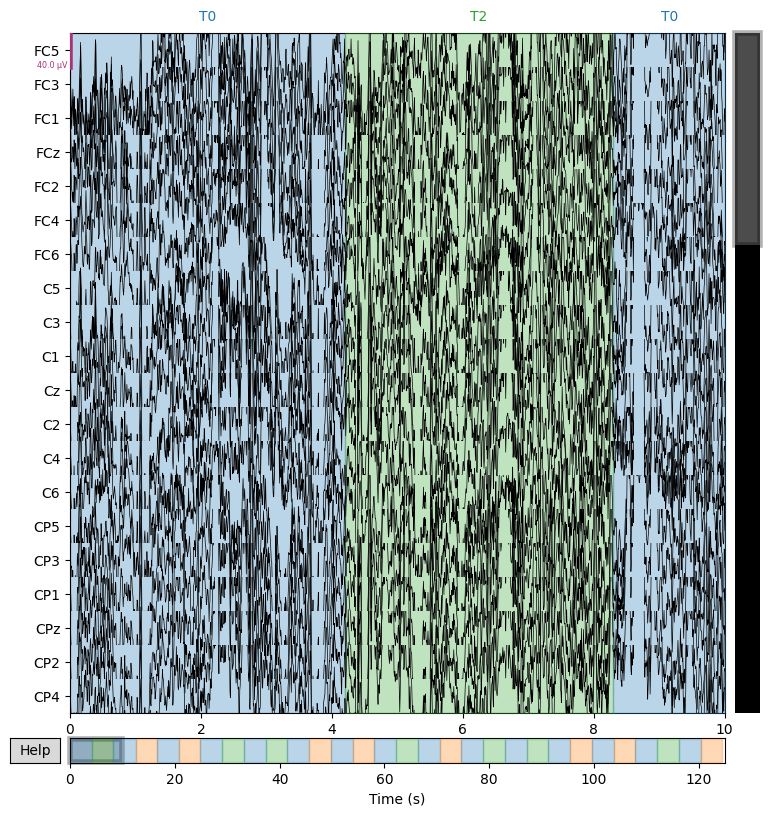

In [16]:
raw_data.plot(picks=picks);


## 6. Show PSD Power Spectral Density

The Power Spectral Density (PSD) is a way to analyze the frequency content of a signal. It tells us how the power of a signal is distributed across different frequencies. 

The PSD describes how the power (or variance) of a signal is distributed over different frequency components.

It is computed using the Fourier Transform, which decomposes a time-domain signal into its frequency components.

Effective window size : 12.800 (s)
Plotting power spectral density (dB=True).


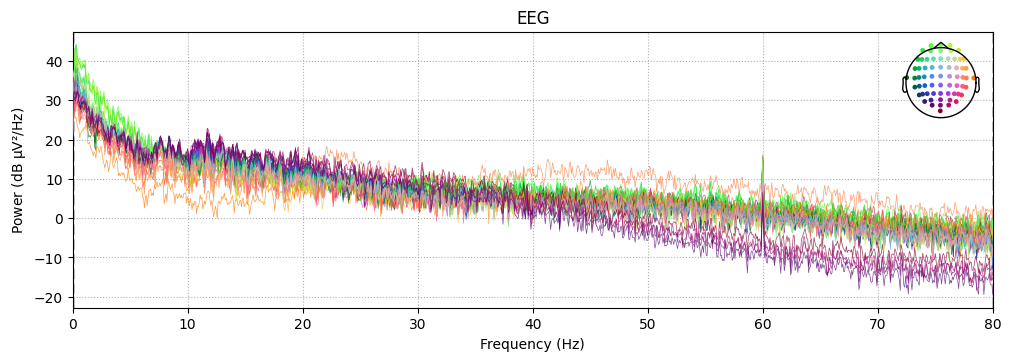

In [17]:
psd = raw_data.compute_psd(picks=picks)
psd.plot();


## 7. Apply ICA Independent Component Analysis

ICA (Independent Component Analysis) is a technique used to separate mixed signals into independent components. In EEG/MEG analysis, it is mainly used to remove artifacts such as eye blinks, eye movements, and muscle noise.

ICA decomposes a signal into a set of statistically independent components, allowing us to identify and remove noise sources without affecting neural signals.

ICA is useful for:
- Removing eye blink artifacts (blinks)
- Removing eye movement and muscle artifacts
- Separating neural activity from external noise


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 70 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 70.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 75.00 Hz)
- Filter length: 529 samples (3.306 s)

Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 25 components


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 2.2s.
Creating RawArray with float64 data, n_channels=25, n_times=20000
    Range : 0 ... 19999 =      0.000 ...   124.994 secs
Ready.


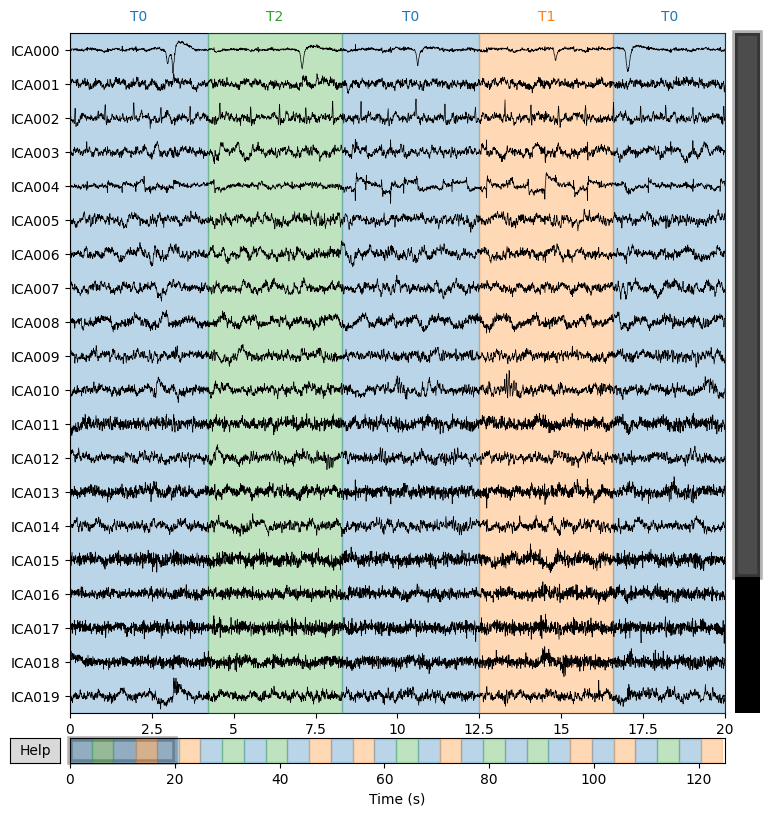

In [18]:
# Configure ICA with 25 components
raw_data_ica = raw_data.copy()
raw_data_ica_filtered = raw_data_ica.filter(1, 70, picks=picks)
ica = ICA(n_components=25, random_state=42, method='fastica', max_iter=800)

# Fit ICA to the data
ica.fit(raw_data_ica_filtered, picks=picks)

# Plot ICA components
ica.plot_sources(raw_data_ica_filtered, picks=range(0, 25))
plt.show()


In [19]:
ica.apply(raw_data_ica_filtered)


Applying ICA to Raw instance
    Transforming to ICA space (25 components)
    Zeroing out 0 ICA components
    Projecting back using 64 PCA components


<RawEDF | S001R03.edf, 64 x 20000 (125.0 s), ~9.8 MiB, data loaded>

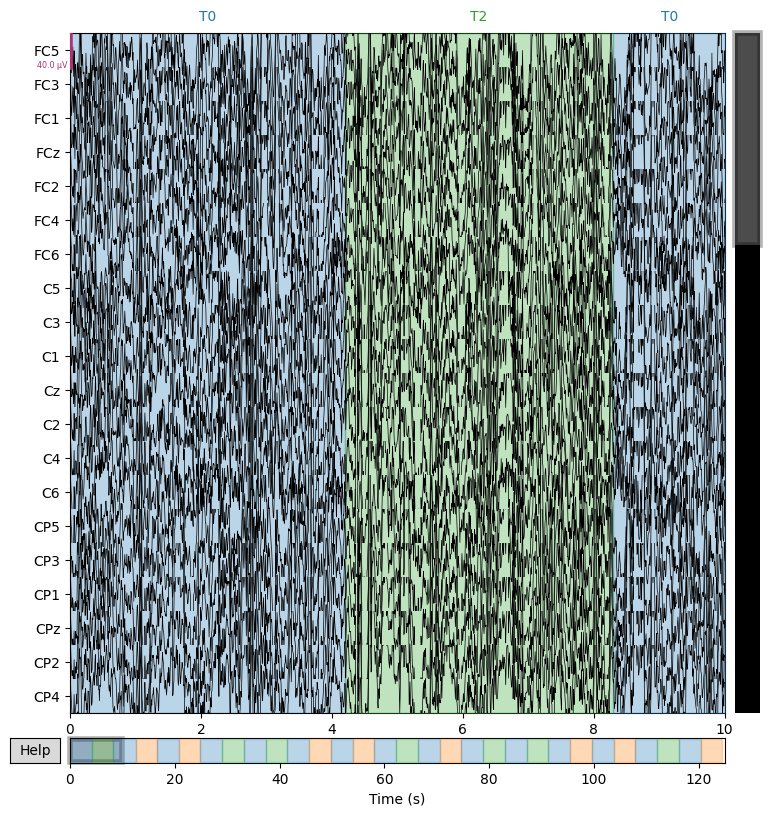

In [20]:
raw_data_ica_filtered.plot(picks=picks);


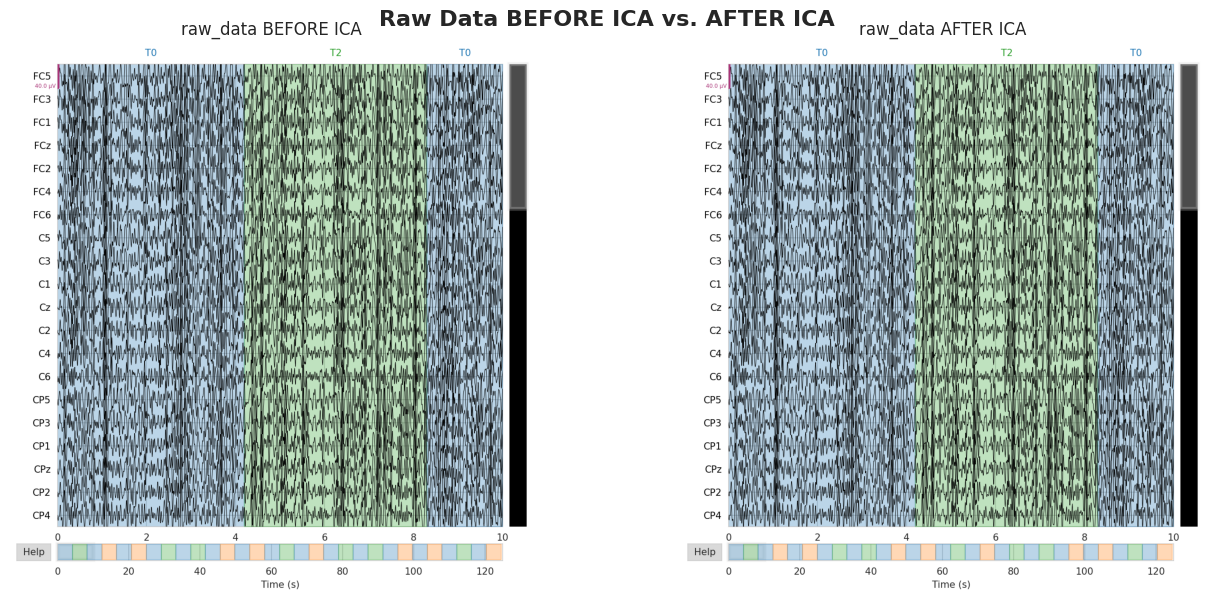

In [51]:
# Function to convert MNE plot to an image
def raw_plot_to_image(raw_data, picks):
    buf = BytesIO()
    fig = raw_data.plot(picks=picks, show=False)
    fig.savefig(buf, format='png', bbox_inches='tight', dpi=150)  # Reduce empty space
    plt.close(fig)
    buf.seek(0)
    return np.array(Image.open(buf))

# Create figure with tight layout
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Raw Data BEFORE ICA vs. AFTER ICA', fontsize=16, fontweight='bold')

# Plot BEFORE ICA
img_before = raw_plot_to_image(raw_data, picks)
axes[0].imshow(img_before)
axes[0].set_title('raw_data BEFORE ICA', fontsize=12)
axes[0].axis('off')  # Hide axes completely
axes[0].spines[:].set_visible(False)  # Hide borders

# Plot AFTER ICA
img_after = raw_plot_to_image(raw_data_ica_filtered, picks)
axes[1].imshow(img_after)
axes[1].set_title('raw_data AFTER ICA', fontsize=12)
axes[1].axis('off')  # Hide axes completely
axes[1].spines[:].set_visible(False)

# Use tight_layout to optimize spacing
plt.tight_layout(pad=0.1, w_pad=0.1, h_pad=0.1)  # Reduce the space between subplots

plt.show()


Effective window size : 12.800 (s)
Plotting power spectral density (dB=True).


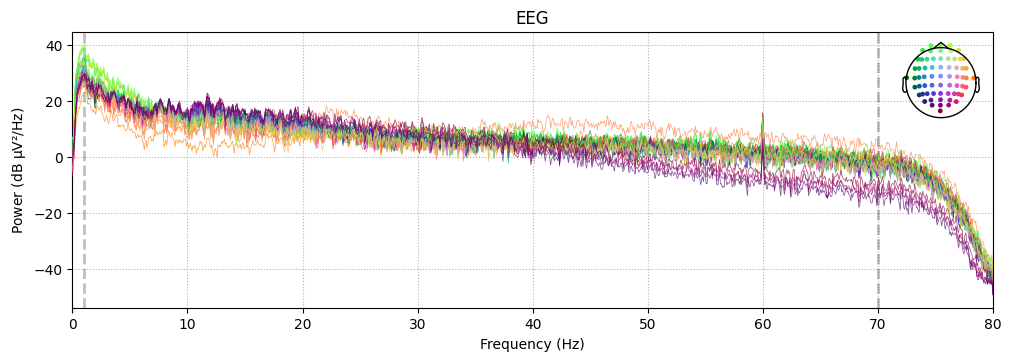

In [22]:
psd_ica_raw = raw_data_ica_filtered.compute_psd(picks=picks, fmax=80)
psd_ica_raw.plot();


## 8. Notch filter

A Notch Filter (also called a Band-stop filter) is used to remove specific unwanted frequencies from a signal, particularly when a narrow frequency band causes interference or noise. In signal processing, the "notch" refers to the removal of frequencies within a small range, leaving the other frequencies untouched.

**How It Works:**

- Passband and Stopband:

	- The passband is the range of frequencies that the filter allows to pass through without attenuation.
	- The stopband is the range of frequencies that the filter suppresses.
	- A notch filter specifically targets and reduces a narrow band of frequencies (the notch), while passing frequencies outside of that band.

- Frequency Range:

	- The notch filter is designed to attenuate a specific frequency (or a small range of frequencies) while allowing the other frequencies to pass through. This is particularly useful when dealing with known interference frequencies, such as the power line frequency (50 Hz or 60 Hz) that can appear in many electrical signals.

**Applications of Notch Filters:** 
- Power line interference: In electrical signals, the 50 Hz or 60 Hz power line frequency is a common source of noise. The notch filter is used to remove this frequency without affecting the rest of the signal.
- Electroencephalography (EEG): In EEG data, notch filters are commonly applied to remove noise caused by electrical equipment, such as power line interference.
- Audio processing: It can also be used to remove hum or buzz noises caused by equipment, such as electrical hum from a microphone or speakers.
- Communication systems: To filter out specific unwanted frequencies or interference.

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1057 samples (6.606 s)

Effective window size : 12.800 (s)
Plotting power spectral density (dB=True).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


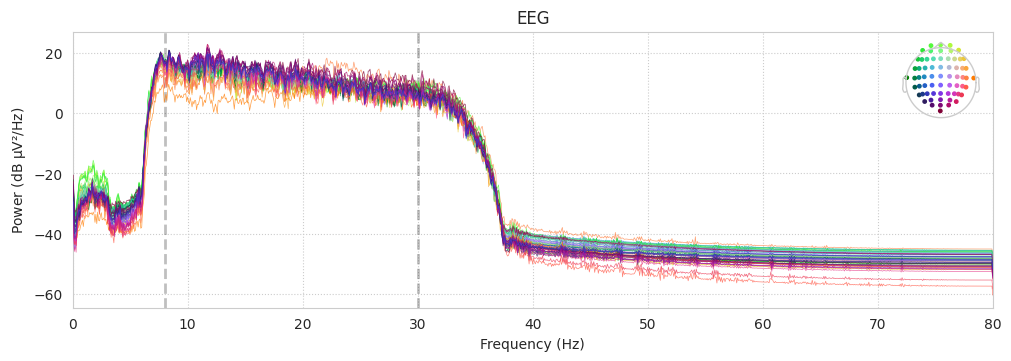

In [43]:
# Notch filter
notch_freq = 60
raw_data_ica_notch = raw_data_ica_filtered.notch_filter(notch_freq, fir_design='firwin')
raw_data_ica_notch.compute_psd().plot();


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

Effective window size : 12.800 (s)
Plotting power spectral density (dB=True).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Effective window size : 12.800 (s)
Plotting power spectral density (dB=True).
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 12.800 (s)
Plotting power spectral density (dB=True).


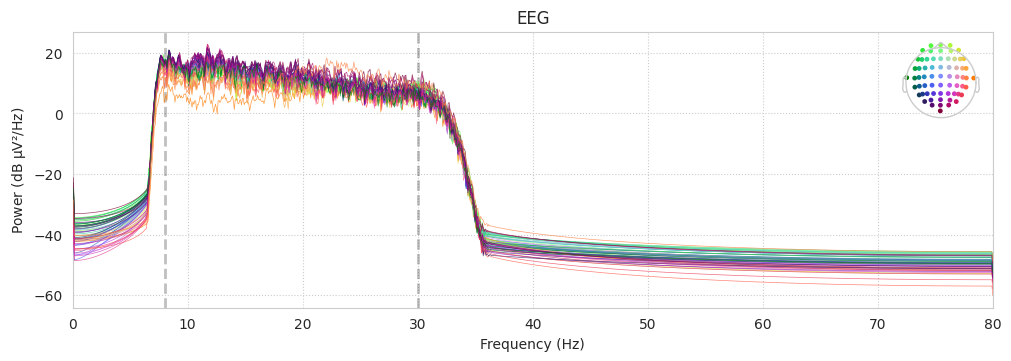

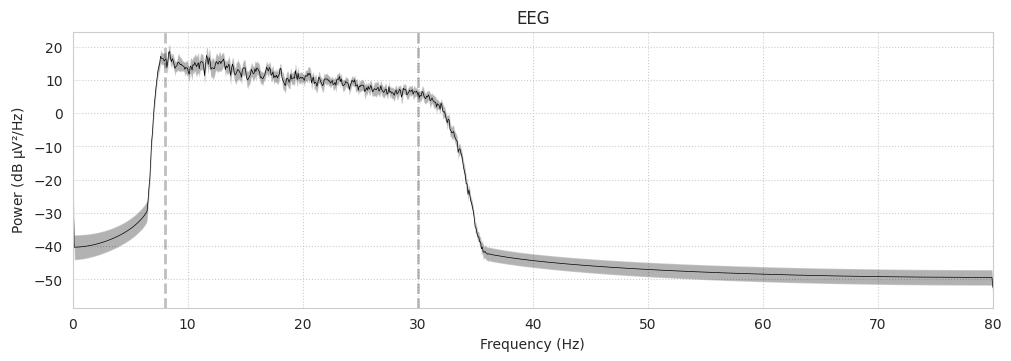

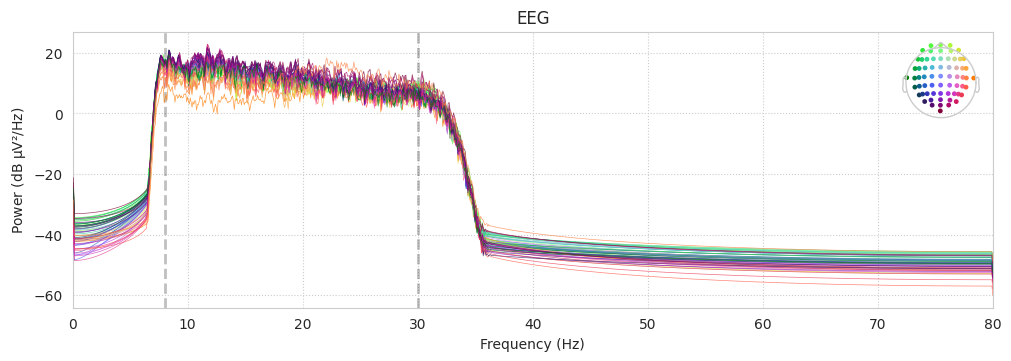

In [45]:
# Band-pass filter keep only alpha and beta waves
low_cutoff = 8
high_cutoff = 30
raw_data_ica_notch.filter(low_cutoff, high_cutoff, fir_design='firwin')
raw_data_ica_notch.compute_psd().plot();
raw_data_ica_notch.compute_psd().plot(average=True);


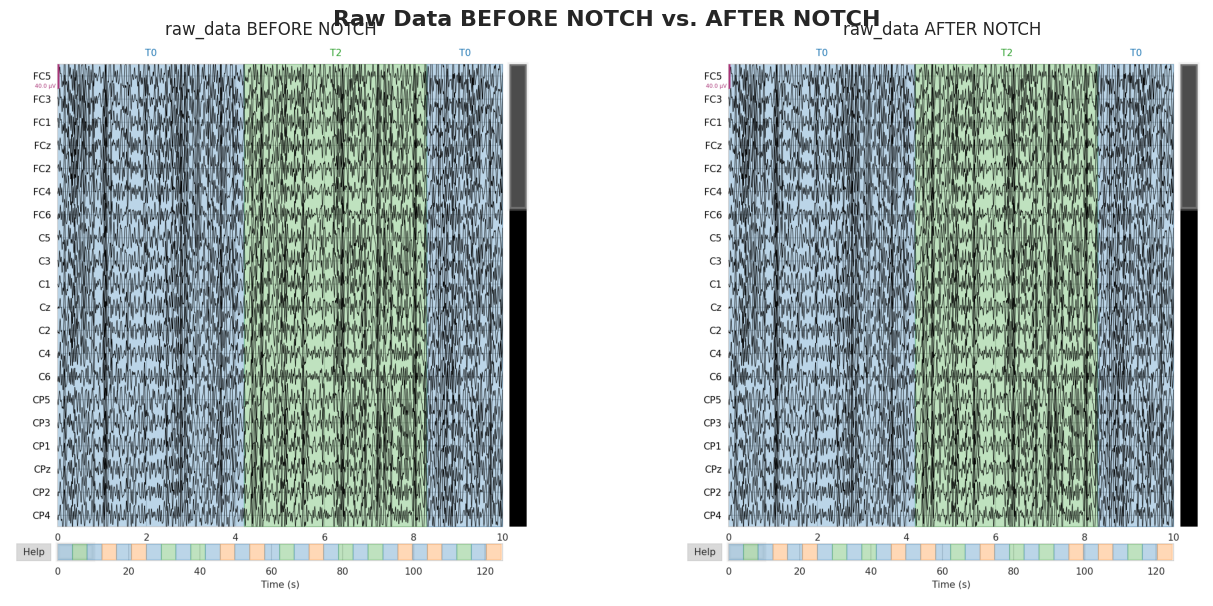

In [52]:
# Function to convert MNE plot to an image
def raw_plot_to_image(raw_data, picks):
    buf = BytesIO()
    fig = raw_data.plot(picks=picks, show=False)
    fig.savefig(buf, format='png', bbox_inches='tight', dpi=150)  # Reduce empty space
    plt.close(fig)
    buf.seek(0)
    return np.array(Image.open(buf))

# Create figure with tight layout
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Raw Data BEFORE NOTCH vs. AFTER NOTCH', fontsize=16, fontweight='bold')

# Plot BEFORE NOTCH
img_before = raw_plot_to_image(raw_data_ica_filtered, picks)
axes[0].imshow(img_before)
axes[0].set_title('raw_data BEFORE NOTCH', fontsize=12)
axes[0].axis('off')  # Hide axes completely
axes[0].spines[:].set_visible(False)  # Hide borders

# Plot AFTER NOTCH
img_after = raw_plot_to_image(raw_data_ica_notch, picks)
axes[1].imshow(img_after)
axes[1].set_title('raw_data AFTER NOTCH', fontsize=12)
axes[1].axis('off')  # Hide axes completely
axes[1].spines[:].set_visible(False)

# Use tight_layout to optimize spacing
plt.tight_layout(pad=0.1, w_pad=0.1, h_pad=0.1)  # Reduce the space between subplots

plt.show()


## 9. Analysis PCA

PCA (Principal Component Analysis) is like taking a photo of complex data from different angles to find the best view that shows the most important information.

***Simple Example:***

Imagine you have photos of faces:

Instead of describing each face with hundreds of pixels
PCA finds the main "features" like: overall shape, eye size, smile, etc.
These main features are the "principal components"
You can describe most faces with just these key features

**In EEG Context:**

- *Starting Point:*
	- You have EEG data with many channels (64 electrodes)
	- Each channel records brain activity
	- Too much data to analyze easily

- *What PCA Does:*
	- Finds the most important patterns in your data
	- Combines related channels into "components"
	- Ranks these components by importance
	- Lets you keep only the important ones

- *Key Benefits:*
	- Reduces noise in the data
	- Makes the data easier to analyze
	- Helps identify main patterns of brain activity

2025-02-17 21:06:19,448 - INFO - Starting data preprocessing...
2025-02-17 21:06:19,464 - INFO - Data preprocessing completed.
2025-02-17 21:06:19,464 - INFO - Computing PCA...
2025-02-17 21:06:19,499 - INFO - PCA computation completed.
2025-02-17 21:06:19,500 - INFO - Optimal components for 95.0% variance: 10


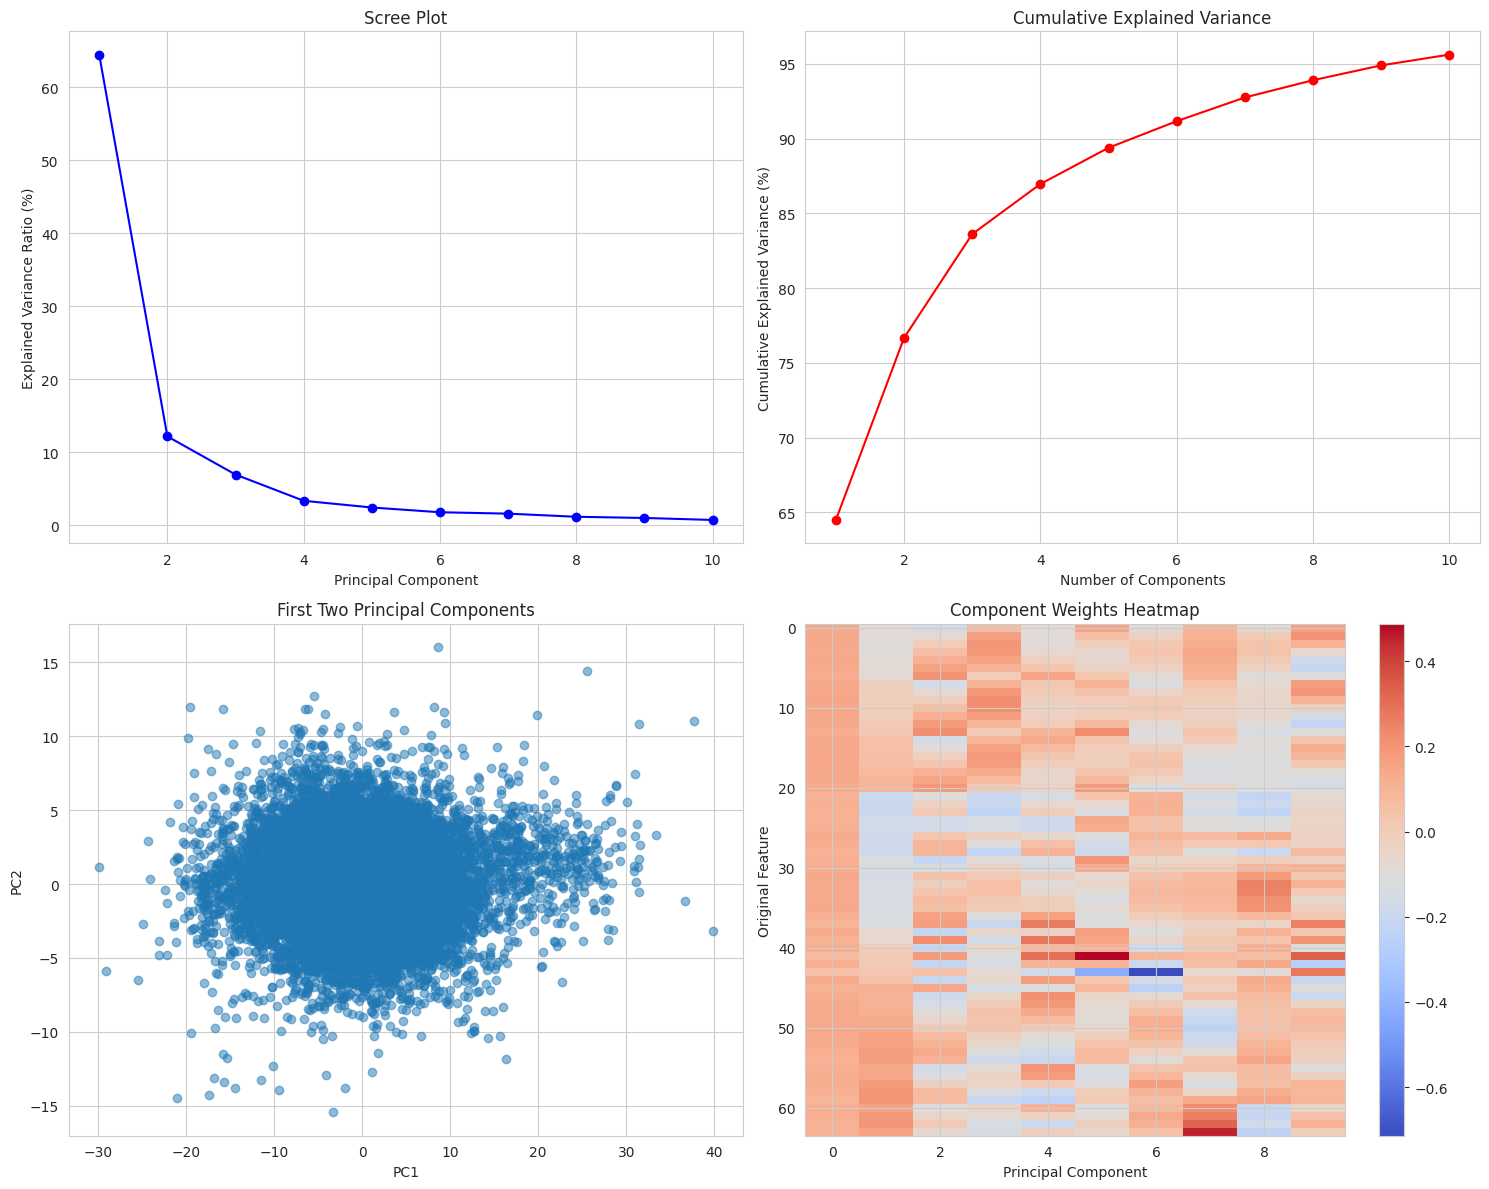


PCA Analysis Summary:
Optimal number of components: 10

Component details:
   Component  Eigenvalue  Explained_Variance(%)  Cumulative_Variance(%)
0          1   41.282866              64.501253               64.501253
1          2    7.792759              12.175577               76.676830
2          3    4.443366               6.942412               83.619241
3          4    2.142550               3.347566               86.966808
4          5    1.552905               2.426293               89.393101
5          6    1.137507               1.777265               91.170366
6          7    1.014467               1.585025               92.755391
7          8    0.739099               1.154784               93.910176
8          9    0.635176               0.992413               94.902589
9         10    0.460936               0.720176               95.622765


In [58]:
def setup_logging() -> logging.Logger:
    """Configure logging for the analysis."""
    logger = logging.getLogger('pca_analysis')
    logger.setLevel(logging.INFO)
    if not logger.handlers:
        handler = logging.StreamHandler()
        formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
        handler.setFormatter(formatter)
        logger.addHandler(handler)
    return logger

def preprocess_data(data: np.ndarray, logger: logging.Logger) -> np.ndarray:
    """
    Preprocess the EEG data by standardizing and handling missing values.
    
    Args:
        data: Raw EEG data array of shape (n_channels, n_samples)
        logger: Logger instance
    
    Returns:
        Standardized data array
    """
    logger.info("Starting data preprocessing...")
    
    # Handle missing and infinite values
    if np.any(np.isnan(data)):
        logger.warning("NaN values found in data. Replacing with zeros.")
        data = np.nan_to_num(data)
    
    if np.any(np.isinf(data)):
        logger.warning("Infinite values found in data. Replacing with zeros.")
        data = np.nan_to_num(data, posinf=0, neginf=0)
    
    # Standardize the data
    scaler = StandardScaler()
    standardized_data = scaler.fit_transform(data.T).T
    
    logger.info("Data preprocessing completed.")
    return standardized_data

def compute_pca(data: np.ndarray, logger: logging.Logger) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Compute PCA on the preprocessed data.
    
    Args:
        data: Preprocessed data array
        logger: Logger instance
    
    Returns:
        Tuple containing eigenvalues, eigenvectors, explained variance ratio, and cumulative variance
    """
    logger.info("Computing PCA...")
    
    # Compute covariance matrix
    covariance_matrix = np.cov(data)
    
    # Compute eigenvalues and eigenvectors using eigh for symmetric matrices
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
    
    # Sort in descending order
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    # Calculate variance ratios
    explained_variance_ratio = eigenvalues / np.sum(eigenvalues) * 100
    cumulative_variance = np.cumsum(explained_variance_ratio)
    
    logger.info("PCA computation completed.")
    return eigenvalues, eigenvectors, explained_variance_ratio, cumulative_variance

def find_optimal_components(cumulative_variance: np.ndarray, 
                          threshold: float = 95.0,
                          logger: logging.Logger = None) -> int:
    """
    Find optimal number of components based on explained variance threshold.
    
    Args:
        cumulative_variance: Array of cumulative explained variance
        threshold: Minimum cumulative variance to explain (default: 95%)
        logger: Logger instance
    
    Returns:
        Optimal number of components
    """
    optimal_components = np.argmax(cumulative_variance >= threshold) + 1
    if logger:
        logger.info(f"Optimal components for {threshold}% variance: {optimal_components}")
    return optimal_components

def transform_data(data: np.ndarray, 
                  eigenvectors: np.ndarray, 
                  n_components: int) -> np.ndarray:
    """
    Transform data using selected principal components.
    
    Args:
        data: Preprocessed data array
        eigenvectors: Matrix of eigenvectors
        n_components: Number of components to use
        
    Returns:
        Transformed data array
    """
    return np.dot(eigenvectors[:, :n_components].T, data)

def create_components_dataframe(eigenvalues: np.ndarray, 
                              explained_variance_ratio: np.ndarray,
                              cumulative_variance: np.ndarray) -> pd.DataFrame:
    """
    Create a DataFrame with PCA component information.
    
    Args:
        eigenvalues: Array of eigenvalues
        explained_variance_ratio: Array of explained variance ratios
        cumulative_variance: Array of cumulative variance
        
    Returns:
        DataFrame with component information
    """
    return pd.DataFrame({
        'Component': range(1, len(eigenvalues) + 1),
        'Eigenvalue': eigenvalues,
        'Explained_Variance(%)': explained_variance_ratio,
        'Cumulative_Variance(%)': cumulative_variance
    })

def plot_pca_results(explained_variance_ratio: np.ndarray,
                    cumulative_variance: np.ndarray,
                    transformed_data: np.ndarray,
                    eigenvectors: np.ndarray,
                    max_components: Optional[int] = None) -> None:
    """
    Create visualization plots for PCA results.
    
    Args:
        explained_variance_ratio: Array of explained variance ratios
        cumulative_variance: Array of cumulative variance
        transformed_data: Transformed data array
        eigenvectors: Matrix of eigenvectors
        max_components: Maximum number of components to plot
    """
    if max_components is None:
        max_components = min(10, len(explained_variance_ratio))
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Scree plot
    axes[0, 0].plot(range(1, max_components + 1), 
                    explained_variance_ratio[:max_components],
                    'bo-')
    axes[0, 0].set_title('Scree Plot')
    axes[0, 0].set_xlabel('Principal Component')
    axes[0, 0].set_ylabel('Explained Variance Ratio (%)')
    axes[0, 0].grid(True)
    
    # Cumulative variance plot
    axes[0, 1].plot(range(1, max_components + 1),
                    cumulative_variance[:max_components],
                    'ro-')
    axes[0, 1].set_title('Cumulative Explained Variance')
    axes[0, 1].set_xlabel('Number of Components')
    axes[0, 1].set_ylabel('Cumulative Explained Variance (%)')
    axes[0, 1].grid(True)
    
    # First two principal components
    if transformed_data.shape[0] >= 2:
        axes[1, 0].scatter(transformed_data[0, :],
                          transformed_data[1, :],
                          alpha=0.5)
        axes[1, 0].set_title('First Two Principal Components')
        axes[1, 0].set_xlabel('PC1')
        axes[1, 0].set_ylabel('PC2')
        axes[1, 0].grid(True)
    
    # Component weights heatmap
    if max_components <= 10:
        im = axes[1, 1].imshow(
            eigenvectors[:, :max_components],
            aspect='auto',
            cmap='coolwarm'
        )
        axes[1, 1].set_title('Component Weights Heatmap')
        axes[1, 1].set_xlabel('Principal Component')
        axes[1, 1].set_ylabel('Original Feature')
        plt.colorbar(im, ax=axes[1, 1])
    
    plt.tight_layout()
    plt.show()

def analyze_eeg_pca(raw_data: np.ndarray, variance_threshold: float = 95.0) -> Dict:
    """
    Main function to perform PCA analysis on EEG data.
    
    Args:
        raw_data: Raw EEG data array
        variance_threshold: Threshold for explained variance
    
    Returns:
        Dictionary containing analysis results
    """
    # Setup logging
    logger = setup_logging()
    
    # Preprocess data
    standardized_data = preprocess_data(raw_data, logger)
    
    # Compute PCA
    eigenvalues, eigenvectors, explained_variance_ratio, cumulative_variance = compute_pca(
        standardized_data, logger
    )
    
    # Find optimal number of components
    n_components = find_optimal_components(
        cumulative_variance, 
        threshold=variance_threshold,
        logger=logger
    )
    
    # Transform data
    transformed_data = transform_data(
        standardized_data, 
        eigenvectors, 
        n_components
    )
    
    # Create components DataFrame
    components_df = create_components_dataframe(
        eigenvalues,
        explained_variance_ratio,
        cumulative_variance
    )
    
    # Plot results
    plot_pca_results(
        explained_variance_ratio,
        cumulative_variance,
        transformed_data,
        eigenvectors
    )
    
    return {
        'eigenvalues': eigenvalues,
        'eigenvectors': eigenvectors,
        'explained_variance_ratio': explained_variance_ratio,
        'cumulative_variance': cumulative_variance,
        'transformed_data': transformed_data,
        'components_df': components_df,
        'n_components': n_components
    }

# Ejemplo de uso
if __name__ == "__main__":
    # Asumiendo que raw_data_ica_notch es tu dato preprocesado
    raw_data = raw_data_ica_notch.copy().get_data()
    
    # Ejecutar análisis PCA
    results = analyze_eeg_pca(raw_data, variance_threshold=95.0)
    
    # Imprimir resumen
    print("\nPCA Analysis Summary:")
    print(f"Optimal number of components: {results['n_components']}")
    print("\nComponent details:")
    print(results['components_df'].head(10))
